In [1]:
import os
import sys
sys.path.append(os.getcwd())
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from khrylib.utils.tools import *
import cv2
from motion_imitation.data_process.nrel_data_read import *

sys.path.append(os.getcwd())
import matplotlib.pyplot as plt

from khrylib.utils import *

from motion_imitation.envs.humanoid_im import HumanoidEnv
from motion_imitation.envs.humanoid_pk import HumanoidEnvProthesis
from motion_imitation.envs.humanoid_ia import HumanoidImpAwareEnv
from motion_imitation.utils.config import Config 
import matplotlib.pyplot as plt
import glfw


In [2]:
from motion_imitation.utils.tools import *
import pickle
cfg = Config('0202', False, create_dirs=False)

cfg.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)
env.seed(cfg.seed)


expert_qpos, expert_meta = pickle.load(open(cfg.expert_traj_file, "rb"))
expert = get_expert(expert_qpos, expert_meta, env)


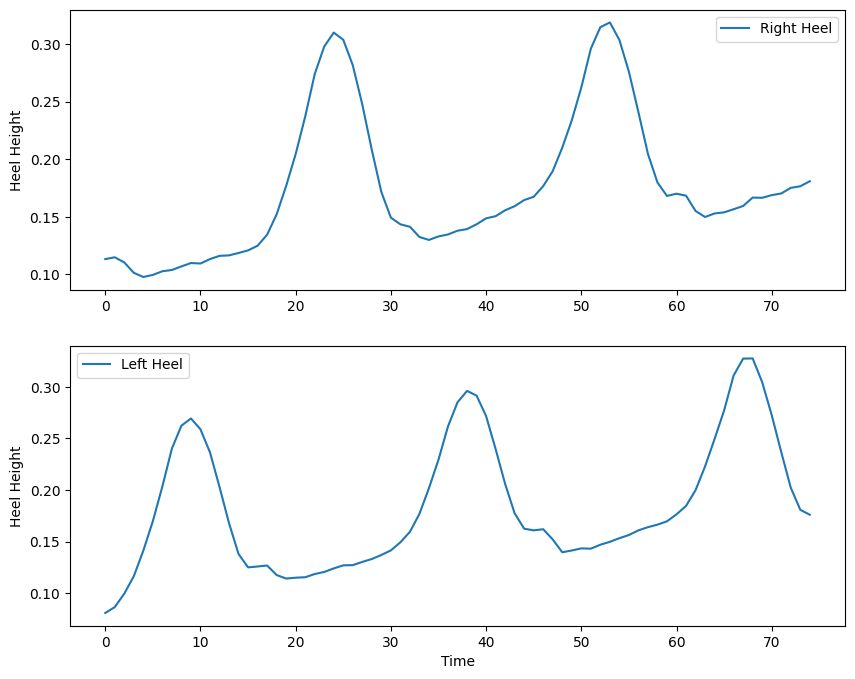

In [3]:
z_heel = expert['ee_wpos'][:, 2:6:3]
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot right heel height
axs[0].plot(z_heel[:, 0], label='Right Heel')
axs[0].set_ylabel('Heel Height')
axs[0].legend()

# Plot left heel height
axs[1].plot(z_heel[:, 1], label='Left Heel')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Heel Height')
axs[1].legend()

plt.show()


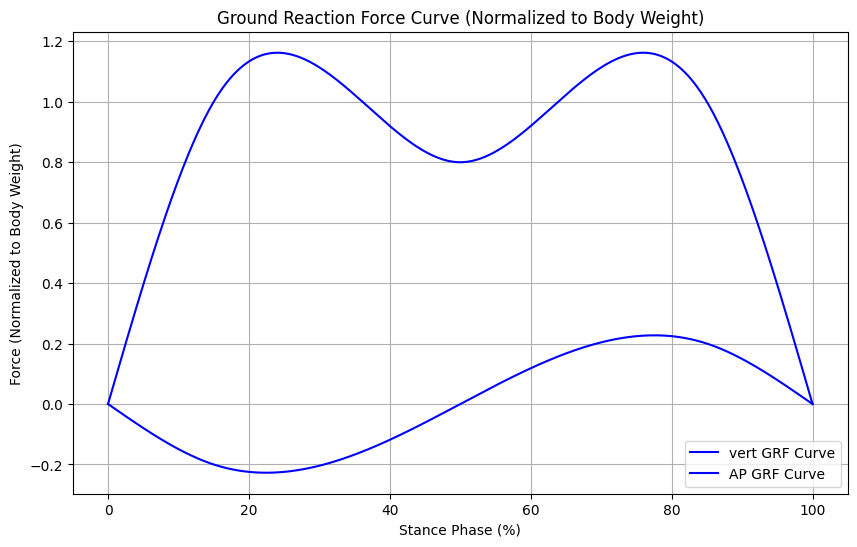

In [4]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

def generate_interpolated_grf(t):
    # Define key timing points and force values for vertical and AP forces
    time_points = [0, 15, 50, 85, 100]  # Percentage of stance phase
    force_vert_points = [0, 1.0, 0.8, 1.0, 0]  # Normalized to body weight
    
    force_ap_points = [0, -0.2, 0, 0.2, 0]  # Example AP force values

    # Create cubic spline interpolation for vertical and AP forces
    cs_vert = CubicSpline(time_points, force_vert_points, bc_type='natural')
    cs_ap = CubicSpline(time_points, force_ap_points, bc_type='natural')
    
    return cs_vert(t), cs_ap(t)


# Generate interpolated GRF curve

# Generate interpolated values
time_fine = np.linspace(0, 100, 500)  # High-resolution time points
force_vert, force_ap  = generate_interpolated_grf(time_fine)
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_fine, force_vert, label='vert GRF Curve', color='blue')
plt.plot(time_fine, force_ap, label='AP GRF Curve', color='blue')
plt.title('Ground Reaction Force Curve (Normalized to Body Weight)')
plt.xlabel('Stance Phase (%)')
plt.ylabel('Force (Normalized to Body Weight)')
plt.legend()
plt.grid()
plt.show()

right heel strike time [0,30,60]
offset period 15 
stance period 18

fit the ideal ground reaction force based on this infomation. 

(75, 3) (75, 3)


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

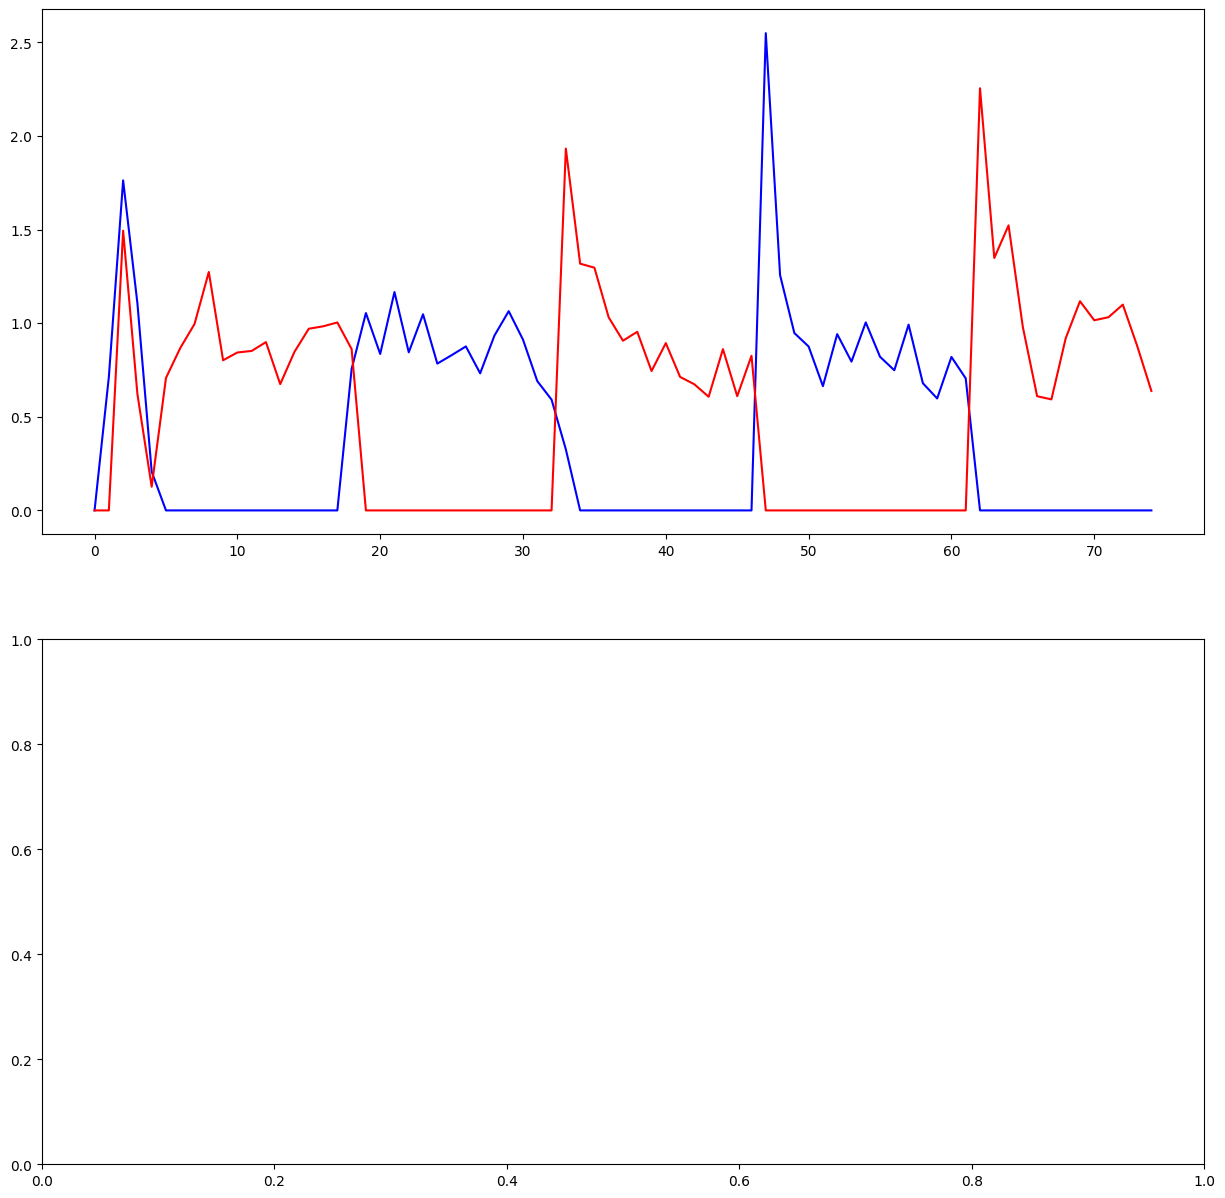

In [ ]:
# hard coded for 0202
def get_ideal_grf(total_idx = 76, rhs_index = [0,30,60], offset_period = 15, stance_period = 18):
    grf = np.zeros((total_idx, 2))
    grf_ap = np.zeros((total_idx, 2))

    # for 1 row (right), 0 row (left)
    for i in rhs_index: 
        if i + stance_period > total_idx:
            grf[i:, 1], grf_ap[i:, 1] = generate_interpolated_grf(np.linspace(0, 100, total_idx-i))[:total_idx-i]
            continue
    
        if i + stance_period + offset_period > total_idx:
            grf[i:, 0], grf_ap[i:, 1] = generate_interpolated_grf(np.linspace(0, 100, total_idx-i - offset_period))[:total_idx-i-offset_period]
            continue
        
        grf [i:i+stance_period,1], grf_ap[i:i+stance_period,1] = generate_interpolated_grf(np.linspace(0, 100, stance_period))  # High-resolution time point
        grf [i+offset_period:i+stance_period+offset_period, 0], grf_ap[i+offset_period:i+stance_period+offset_period, 0] = generate_interpolated_grf(np.linspace(0, 100, stance_period))
        
    return grf, grf_ap


grf_actual_l = np.load('grf_l.npy')
grf_actual_r = np.load('grf_r.npy')

print(grf_actual_r.shape, grf_actual_l.shape)


i = 75
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].plot(grf_actual_r[:,2]/env.mass/9.81, 'b-', label=f'Right vert actual (i={i})')
ax[0].plot(grf_actual_l[:,2]/env.mass/9.81, 'r-', label=f'left vert atual (i={i})')
grf, grf_ap = get_ideal_grf()
ax[0].plot(grf[:,0], 'b:',label='Right vert ideal')
ax[0].plot(grf[:,1], 'r:', label='left vert ideal')
ax[0].legend()

ax[1].plot(grf_actual_r[:,1]/env.mass/9.81, 'b-', label=f'Right AP actual (i={i})')
ax[1].plot(grf_actual_l[:,1]/env.mass/9.81, 'r-', label=f'left AP actual (i={i})')
# grf = get_ideal_grf()
ax[0].plot(grf_ap[:,0], 'b:',label='Right AP ideal')
ax[0].plot(grf_ap[:,1], 'r:', label='left AP ideal')
ax[1].legend()



In [ ]:
poses_gt = []
forces, grfs, jkps = [], [], []
state = env.reset()

action = env.action_space.sample()
for t in range(1000): 
    
    epos = env.get_expert_attr('qpos', env.get_expert_index(t)).copy()
    # print(epos.shape)
    if env.expert['meta']['cyclic']:
        init_pos = env.expert['init_pos']
        cycle_h = env.expert['cycle_relheading']
        cycle_pos = env.expert['cycle_pos']
        epos[:3] = quat_mul_vec(cycle_h, epos[:3] - init_pos) + cycle_pos
        epos[3:7] = quaternion_multiply(cycle_h, epos[3:7])
    poses_gt.append(epos) 

   

poses_gt= np.vstack(poses_gt)


(1000, 39)

In [ ]:
dt = 0.01
fname = 'Walking_passive01_K4'
fname = 'no-rail-W1_High K2'
# fdir = 'data/nrel/Walking_passive01_K4'
fdir = f'data/nrel/{fname}'
frame_dir = f'{fdir}/frame_skeleton'
fpath = os.path.join(fdir, f'{fname}.csv')
coordinates, step_times, body_tree = process_motion_data(fpath, dt)
ts, force_data, moment_data, cop_data = process_force_data(fpath, dt)
force_data["LFz"] *= -1
force_data["RFz"] *= -1


print(ts.shape, force_data.shape, moment_data.shape, cop_data.shape)  

Total time: 30.92 seconds
Time step (dt): 0.01 seconds
Walking speed: 0.6 m/s
(3093,) (3093, 9) (3093, 9) (3093, 9)


In [ ]:
step_times

{'r_s': array([ 0.  ,  0.93,  2.26,  3.5 ,  4.98,  6.45,  7.77,  9.11, 10.42,
        11.72, 13.05, 14.36, 15.64, 16.89, 18.21, 19.47, 20.78, 22.26,
        23.52, 24.78, 25.95, 27.42, 28.7 , 29.98], dtype=float32),
 'r_e': array([ 0.58,  1.92,  3.21,  4.66,  6.15,  7.43,  8.78, 10.09, 11.38,
        12.75, 14.06, 15.32, 16.52, 17.86, 19.1 , 20.36, 21.99, 23.2 ,
        24.46, 25.64, 27.08, 28.38, 29.66], dtype=float32),
 'l_s': array([ 0.27,  1.65,  3.04,  4.2 ,  5.74,  7.19,  8.52,  9.82, 11.14,
        12.45, 13.79, 15.07, 16.28, 17.56, 18.91, 20.16, 21.45, 22.96,
        24.19, 25.42, 26.7 , 28.1 , 29.4 , 30.71], dtype=float32),
 'l_e': array([ 1.19,  2.45,  3.73,  5.16,  6.7 ,  8.  ,  9.33, 10.6 , 11.93,
        13.28, 14.55, 15.83, 17.11, 18.48, 19.81, 21.05, 22.42, 23.69,
        25.01, 26.22, 27.63, 28.95, 30.19], dtype=float32)}

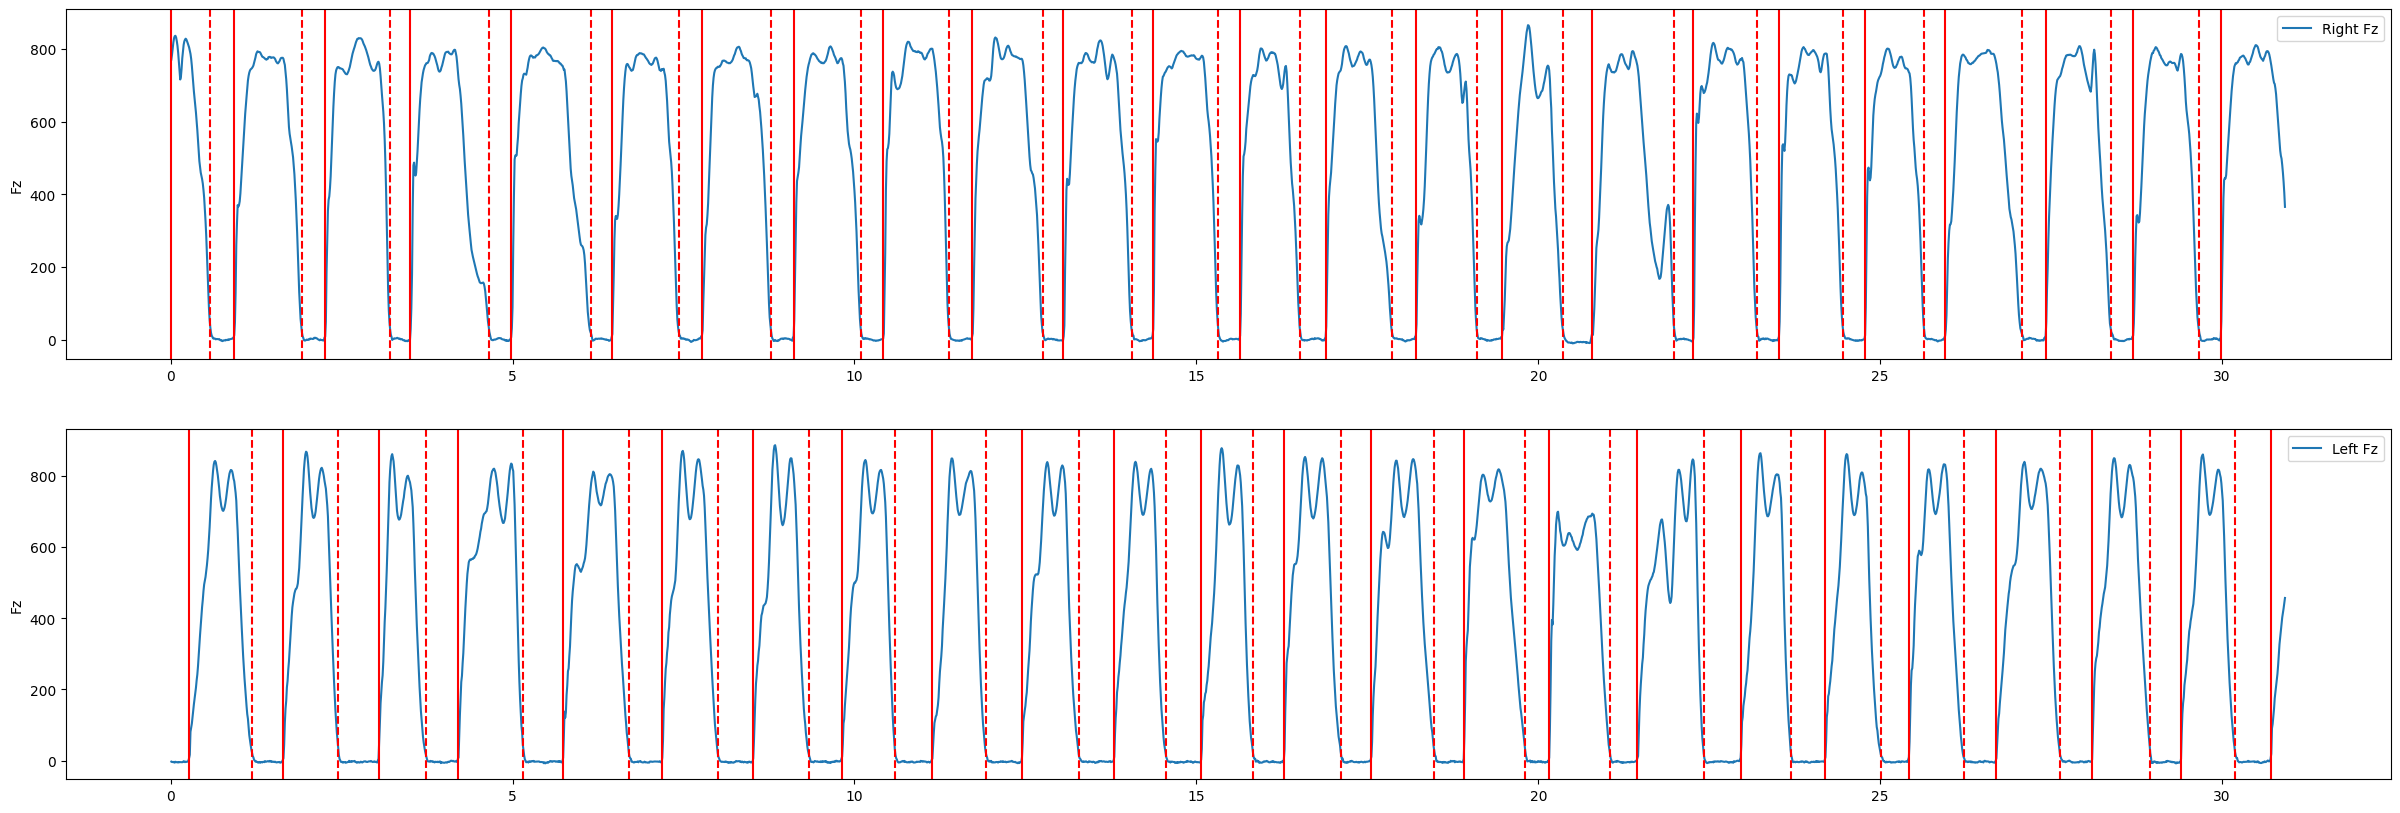

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(30, 10))
if ts is None:
    ts = force_data.index


# Plot Fz
axs[0].plot(ts, force_data['RFz'], label='Right Fz')
# axs[0].plot(ts, force_data['LFz'], label='Left Fz')
for t in step_times['r_s']:
    axs[0].axvline(x=t, color='red')
for t in step_times['r_e']:
    axs[0].axvline(x=t, color = 'red', linestyle='--')
axs[0].set_ylabel('Fz')
axs[0].legend()

axs[1].plot(ts, force_data['LFz'], label='Left Fz')
for t in step_times['l_s']:
    axs[1].axvline(x=t, color='red')
for t in step_times['l_e']:
    axs[1].axvline(x=t, color='red', linestyle='--')
axs[1].set_ylabel('Fz')
axs[1].legend()

In [ ]:
import c3d
import numpy as np
import matplotlib.pyplot as plt

# Open the c3d file
with open('test.c3d', 'rb') as f:
    reader = c3d.Reader(f)

    # Read the GRF data
    grf_data = []
    skeleton = []
    for i, points, analog in reader.read_frames():
        grf_data.append(analog)  # Assuming GRF data is in the first 3 channels
        skeleton.append(points)
    # Transpose the data to get the time series
    grf_data = np.array(grf_data)
    skeleton = np.array(skeleton)
    
grf_data = grf_data[:,:,0]
    

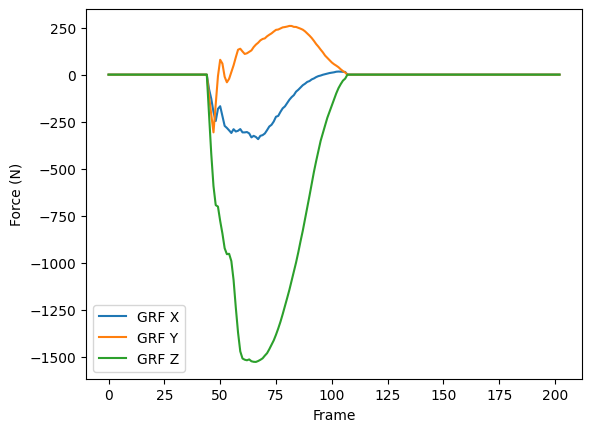

In [ ]:
# Plot the GRF data
plt.plot(grf_data[:,0], label='GRF X')
plt.plot(grf_data[:,1], label='GRF Y')
plt.plot(grf_data[:,2], label='GRF Z')
plt.xlabel('Frame')
plt.ylabel('Force (N)')
plt.legend()
plt.show()

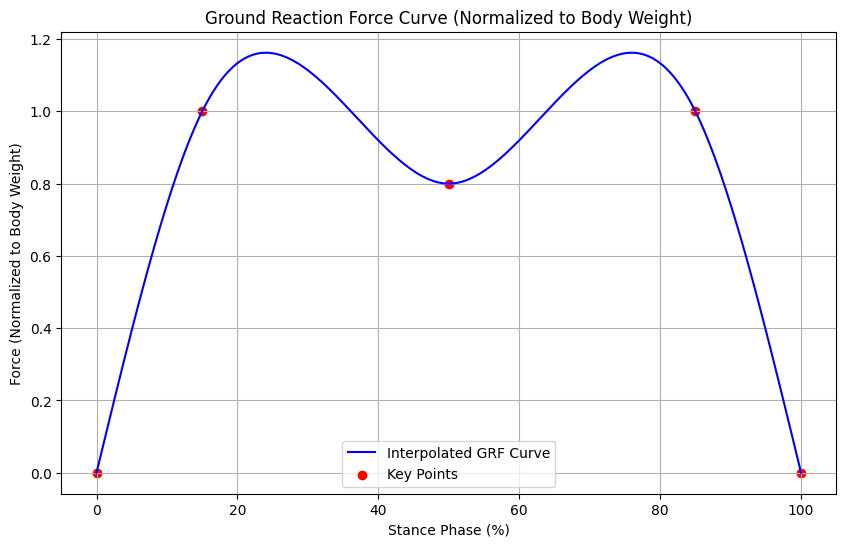